# A Netflix Tour of Data Science - Film suggestion by diffusion on graphs
# Adjacency - Crew

### Students:

    * Team     : 17
    * Students : Edwige Avignon, Kenneth Nguyen, Pierre Fourcade  
    * Dataset  : Kaggle dataset - Films and Crew

## About this notebook:

This notebook is used to create and export an adjacency matrix built from the crew of the movies.
For that we use a dataset regrouping all the needed informations.

The goal here is to build a graph where the nodes represent the different movies of the dataset we are working with, and the edges are determined from the crew. The edges and their weights must represent how strong is the similarity between two movies, according to the informations we have about the crew.
To build a meaningful adjacency matrix from the crew we have taken into account the following points:

1. The crew in the dataset isn't mentioned in a specific order.
2. If no crew informations are mentionned in the dataset the movie is considered as isolated.
3. The weights are determined by the number of common person in the crew of two movies by only considering the following jobs : Director, Executive Producer and Original Music Composer. We have considered that those three jobs in the crew are the most emblematic and are the ones really defining the essence of the movie.

The important point in the weights is not the value in itself, as we will normalize them afterwards, but the gap between the different levels that we have considered.
We can also note that the graph we want to create is undirected.

## 0 - Libraries, database and usefull functions

In [1]:
import numpy as np
import pandas as pd
import pygsp as pg
import networkx as nx
import matplotlib.pyplot as plt
import ast
from collections import Counter

In [2]:
credits = pd.read_csv('Dataset_Exports/tmdb_5000_credits.csv')
movies = pd.read_csv('Dataset_Exports/tmdb_5000_movies.csv')

In [3]:
def convert_list(list_dict):
    newdict={}
    for k,v in [(key,d[key]) for d in 
    ast.literal_eval(list_dict) for key in d]:
        if k not in newdict: newdict[k]=[v]
        else: newdict[k].append(v)
    return newdict

In [4]:
def convert_dict_to_features(x):
    try:
        return x[k]
    except:
        return []

In [5]:
def all_connected_nodes(adjacency):
    connected_nodes = []
    for i in range (len(adjacency)):
        sum = np.sum(adjacency[i])
        if sum != 0:
            connected_nodes.append(i)
    return np.array(connected_nodes)

In [6]:
def remove_isolated_nodes(connected_nodes,adjacency):
    adjacency_connected = np.zeros((len(connected_nodes),len(connected_nodes)))
    for i in range (len(connected_nodes)):
        for j in range (len(connected_nodes)):
              adjacency_connected[i,j] = adjacency[connected_nodes[i],[connected_nodes[j]]] 
    return adjacency_connected

## 1 - Adjacency - Crew

Let's build the adjacency.

For that, at first, we extract the crew from the dataset and we reduce the information to what we are interested in.

In [7]:
compact_dict = credits.crew.apply(lambda x: convert_list(x))
for (k, v) in compact_dict[0].items():
    credits[k] = compact_dict.apply(lambda x: convert_dict_to_features(x))

In [8]:
credits.rename(columns={'id':'crew_id', 'name':'crew_name'},inplace=True)
credits_restricted = credits[['movie_id', 'title', 'crew_id', 'job',]].copy()

In [9]:
credits_restricted.head()

,movie_id,title,crew_id,job
0,19995,Avatar,"[1721, 496, 900, 900, 1262, 1729, 2710, 2710, ...","[Editor, Production Design, Sound Designer, Su..."
1,285,Pirates of the Caribbean: At World's End,"[120, 1704, 770, 1705, 1706, 1721, 1722, 947, ...","[Director of Photography, Director, Producer, ..."
2,206647,Spectre,"[153, 39, 8384, 932, 932, 4248, 9856, 3904, 75...","[Original Music Composer, Director, Set Decora..."
3,49026,The Dark Knight Rises,"[947, 282, 525, 525, 525, 525, 527, 556, 559, ...","[Original Music Composer, Producer, Screenplay..."
4,49529,John Carter,"[7, 7, 7879, 490, 2073, 3996, 6958, 8158, 8166...","[Screenplay, Director, Thanks, Producer, Casti..."


In [10]:
# We reduce the information to only Director, Executive Producer and Original Music Composer:

job_reduced = []
crew_id_reduced = []

for i in range (len(credits_restricted)):
    job = []
    crew_id = []
    job_node  = np.array(credits_restricted.job[i])
    crew_node = np.array(credits_restricted.crew_id[i])
    for j in range (len(job_node)):
        if job_node[j] == 'Original Music Composer' or job_node[j] == 'Executive Producer' or job_node[j] == 'Director':
            job.append(job_node[j])
            crew_id.append(crew_node[j])
    job_reduced.append(job)
    crew_id_reduced.append(crew_id)
    
credits_reduced = credits_restricted[['movie_id','title']].copy()
credits_reduced['job_reduced'] = job_reduced
credits_reduced['crew_id_reduced'] = crew_id_reduced                  

In [11]:
credits_reduced.head()

,movie_id,title,job_reduced,crew_id_reduced
0,19995,Avatar,"[Original Music Composer, Director, Executive ...","[1729, 2710, 20294]"
1,285,Pirates of the Caribbean: At World's End,"[Director, Original Music Composer, Executive ...","[1704, 947, 2444]"
2,206647,Spectre,"[Original Music Composer, Director, Executive ...","[153, 39, 10876]"
3,49026,The Dark Knight Rises,"[Original Music Composer, Director, Executive ...","[947, 525, 10949, 10951, 54211, 75804]"
4,49529,John Carter,[Director],[7]


Now that we have the id of the chosen members of the crews we can build the top-half of the adjacency. Indeed, as it is symmetrical in regards of the diagonal, it is faster to just mirror the top-half after.

In [12]:
adjacency_weighted = np.zeros((len(credits_reduced),len(credits_reduced)))
adjacency = np.zeros((len(credits_reduced),len(credits_reduced)))
np.shape(adjacency)

(4803, 4803)

In [13]:
# We build the top-half of the adjacency:

for i in range (len(credits_reduced)):
    node = np.array(credits_reduced.crew_id_reduced[i])
    for j in range (i+1,len(credits_reduced)):
        other_node = np.array(credits_reduced.crew_id_reduced[j])
        if len(node) == 0 or len(other_node) == 0:
            adjacency_weighted[i,j] = 0
        elif len(node) == 1 or len(other_node) == 1:
            if node[0] == other_node[0]:
                adjacency_weighted[i,j] = 1
            else:
                adjacency_weighted[i,j] = 0
        else:
            match = 0
            node = np.sort(node)
            other_node = np.sort(other_node)
            for k in range (len(node)):
                for l in range (len(other_node)):
                    if node[k] == other_node[l]:
                        match = match + 1
                        break
            adjacency_weighted[i,j] = match

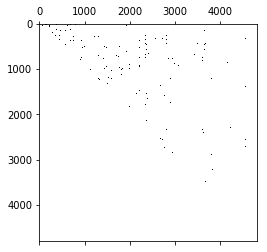

In [14]:
plt.spy(adjacency_weighted)

In [15]:
# We complete the low-half of the adjacency:

for i in range (len(credits_restricted)):
    for j in range (i+1,len(credits_restricted)):
        adjacency_weighted[j,i] = adjacency_weighted[i,j]

In [16]:
# We also build an unweighted adjacency:

for i in range (len(adjacency)):
    for j in range (len(adjacency)):
        if adjacency_weighted[i,j] != 0:
            adjacency[i,j] = 1

In [17]:
# We save the adjacency

np.savetxt('Dataset_Exports/Crew/Adjacency_Crew_Weighted.txt', adjacency_weighted)
np.savetxt('Dataset_Exports/Crew/Adjacency_Crew.txt', adjacency)

Let's normalize the weights.

In [18]:
adjacency_weighted_normalized = np.zeros((len(adjacency_weighted),len(adjacency_weighted)))

In [19]:
# We normalize the weights:

max_weight = np.max(adjacency_weighted)

for i in range (len(adjacency_weighted_normalized)):
    for j in range (len(adjacency_weighted_normalized)):
        if adjacency_weighted[i,j] == 0:
            adjacency_weighted_normalized[i,j] = 0
        else:
            adjacency_weighted_normalized[i,j] = adjacency_weighted[i,j]/max_weight

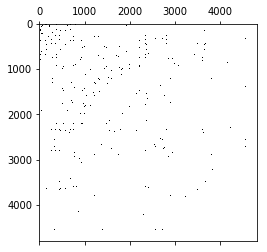

In [20]:
plt.spy(adjacency_weighted_normalized)

In [21]:
np.savetxt('Dataset_Exports/Crew/Adjacency_Crew_Weighted_Normalized.txt', adjacency_weighted_normalized)

## 2 - Exporting the graph for Gephi (by using Networkx)

Now we will create the graph of the adjacency we have built. We can quickly represent it here with Networkx but the core of our observations will be made with Gephi.

In [22]:
adjacency_weighted_normalized = np.loadtxt('Dataset_Exports/Crew/Adjacency_Crew_Weighted_Normalized.txt')

In [23]:
Graph = nx.from_numpy_array(adjacency_weighted_normalized)

D:\Programmes_DD\Applications\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


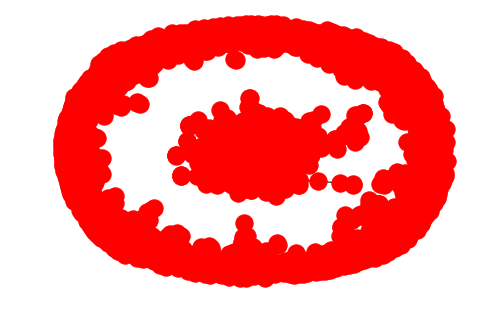

In [24]:
nx.draw_spring(Graph)

In [25]:
nx.write_gexf(Graph,'Dataset_Exports/Crew/Graph_Crew.gexf')